In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

In [4]:

!unzip /content/drive/MyDrive/Classified.zip


Archive:  /content/drive/MyDrive/Classified.zip
   creating: Classified/test/
   creating: Classified/test/Class A/
  inflating: Classified/test/Class A/a1020.png  
  inflating: Classified/test/Class A/a103.png  
  inflating: Classified/test/Class A/a1030.png  
  inflating: Classified/test/Class A/a1043.png  
  inflating: Classified/test/Class A/a1077.png  
  inflating: Classified/test/Class A/a1079.png  
  inflating: Classified/test/Class A/a1082.png  
  inflating: Classified/test/Class A/a1091.png  
  inflating: Classified/test/Class A/a1097.png  
  inflating: Classified/test/Class A/a1098.png  
  inflating: Classified/test/Class A/a1100.png  
  inflating: Classified/test/Class A/a1106.png  
  inflating: Classified/test/Class A/a1118.png  
  inflating: Classified/test/Class A/a1120.png  
  inflating: Classified/test/Class A/a1121.png  
  inflating: Classified/test/Class A/a1124.png  
  inflating: Classified/test/Class A/a1130.png  
  inflating: Classified/test/Class A/a1142.png  
  i

# constants

In [5]:
cd/content/Classified

/content/Classified


In [6]:
IMG_SIZE = 224
DATA_DIR = "/content/Classified"
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
MODEL_PATH = 'saved-models/224-hist-binary2-more-train'

# histogram equalization

In [7]:
def equalize(img):
    img = img.astype('uint8')
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    img = clahe.apply(img)
    img = np.expand_dims(img, 2)
    return img

In [8]:
def compare_equalized(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = equalize(img).squeeze()
    img2 = np.hstack([img, img2])
    plt.imshow(img2, cmap='gray')
    plt.show()

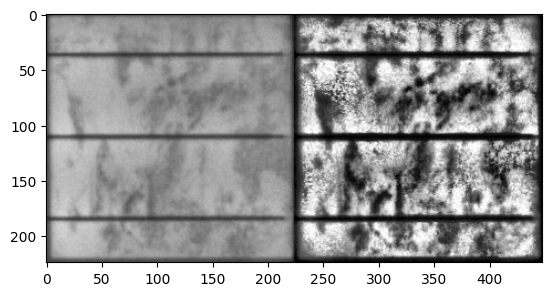

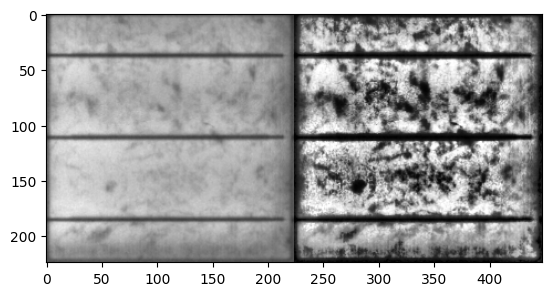

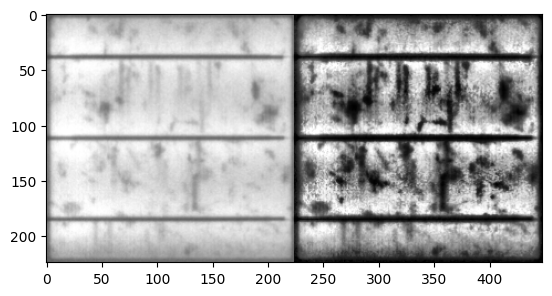

In [9]:
compare_equalized("/content/Classified/val/Class A/a1026.png")
compare_equalized("/content/Classified/val/Class A/a1078.png")
compare_equalized("/content/Classified/val/Class A/a1148.png")

# reading dataset (image data generators)

In [10]:
train_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


val_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, VAL_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


test_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)

Found 2098 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


# cnn model

In [60]:
from tensorflow import keras
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),  input_shape=train_gen[0][0][0].shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2),strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2),strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2),strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Dense(train_gen[0][1].shape[1], activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5) ])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_67 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_67 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_53 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_68 (Conv2D)          (None, 109, 109, 64)    

# training

In [61]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
callbacks = [
            EarlyStopping(patience = 15, verbose=1),
            ReduceLROnPlateau(factor = 0.5, patience = 6, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('/content/model_elpv.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

hist = model.fit(
    train_gen,
    validation_data=val_gen,
    shuffle=True,
    epochs=80,
    callbacks=callbacks,
)


Epoch 1/80
33/33 [==============================] - ETA: 0s - loss: 66.1285 - accuracy: 0.7016 - recall_10: 0.6606 - specificity_at_sensitivity_10: 0.6935
Epoch 1: val_loss improved from inf to 492.77838, saving model to /content/model_elpv.h5
33/33 [==============================] - 19s 482ms/step - loss: 66.1285 - accuracy: 0.7016 - recall_10: 0.6606 - specificity_at_sensitivity_10: 0.6935 - val_loss: 492.7784 - val_accuracy: 0.6870 - val_recall_10: 0.6870 - val_specificity_at_sensitivity_10: 0.6870 - lr: 0.0010
Epoch 2/80
33/33 [==============================] - ETA: 0s - loss: 19.4676 - accuracy: 0.7350 - recall_10: 0.7102 - specificity_at_sensitivity_10: 0.7283
Epoch 2: val_loss improved from 492.77838 to 96.43276, saving model to /content/model_elpv.h5
33/33 [==============================] - 13s 383ms/step - loss: 19.4676 - accuracy: 0.7350 - recall_10: 0.7102 - specificity_at_sensitivity_10: 0.7283 - val_loss: 96.4328 - val_accuracy: 0.6794 - val_recall_10: 0.4504 - val_specifi

In [62]:
model.save("model.h5")

# training history (loss)

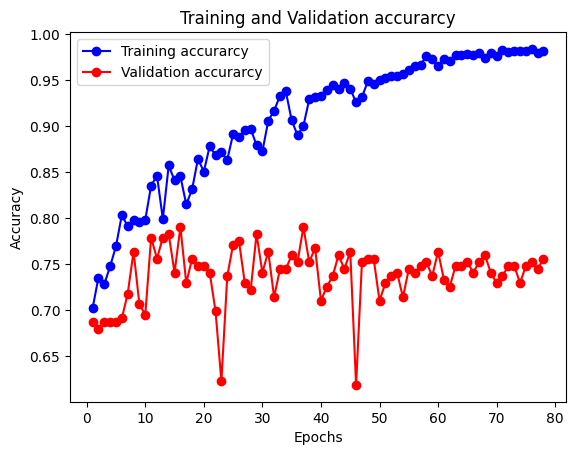

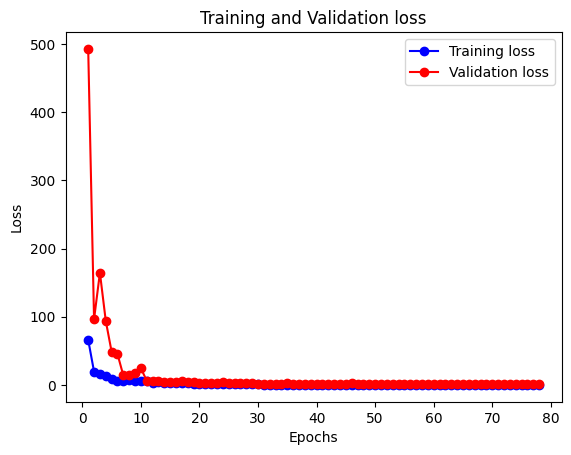

In [63]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# testing

In [64]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

In [65]:
model.evaluate(test_gen)

5/5 [==============================] - 1s 122ms/step - loss: 1.1583 - accuracy: 0.7955 - recall_10: 0.7917 - specificity_at_sensitivity_10: 0.9167


[1.158281683921814, 0.7954545617103577, 0.7916666865348816, 0.9166666865348816]

# confusion matrix

In [66]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]


In [67]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

5/5 [==============================] - 1s 167ms/step
[[1.14711677e-03 9.99083877e-01]
 [9.99986410e-01 5.37715596e-06]
 [9.82896745e-01 1.06470743e-02]
 [1.61028621e-11 1.00000000e+00]
 [9.89004433e-01 7.77125359e-03]
 [1.00000000e+00 2.27514896e-09]
 [6.10920787e-03 9.96931076e-01]
 [5.83541696e-05 9.99978065e-01]
 [9.24471080e-01 5.50821982e-02]
 [9.91605401e-01 7.10496353e-03]
 [6.18252575e-01 2.40083396e-01]
 [1.66335900e-04 9.99964476e-01]
 [9.99075532e-01 3.96104821e-04]
 [9.99937773e-01 1.00040525e-05]
 [9.34970558e-01 5.18928953e-02]
 [1.00000000e+00 4.71062744e-09]
 [2.73196056e-04 9.99965191e-01]
 [1.00000000e+00 8.27566605e-30]
 [6.34682991e-08 1.00000000e+00]
 [9.09794271e-01 6.34183511e-02]
 [1.00000000e+00 9.40678525e-13]
 [9.98680651e-01 2.29994315e-04]
 [9.28359151e-01 9.98647213e-02]
 [9.99998212e-01 3.24679235e-07]
 [1.00000000e+00 3.59299204e-35]
 [9.36690629e-01 4.62258309e-02]
 [9.95814800e-03 9.94450450e-01]
 [4.49029624e-01 5.12528896e-01]
 [9.99998808e-01 4.1478

              precision    recall  f1-score   support

     Class A       0.87      0.82      0.85       181
     Class B       0.66      0.73      0.69        83

    accuracy                           0.80       264
   macro avg       0.76      0.78      0.77       264
weighted avg       0.80      0.80      0.80       264



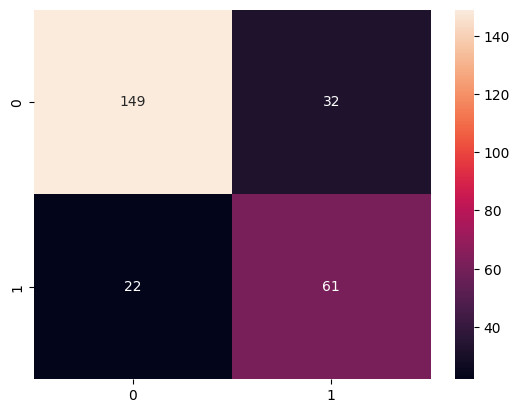

In [68]:
import seaborn as sn
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test_int, y_pred_test_int)
sn.heatmap(cm,annot=True,fmt="d")

target_names = ['Class A', 'Class B']
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))

In [69]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_int, y_pred_test_int))

0.7954545454545454
